In [1]:
library(ggvenn)
library(tidyverse)
library(RColorBrewer)
library(eulerr)
library(ggplotify)

# Custom package
library(rutils)

Loading required package: dplyr


Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union


Loading required package: grid

Loading required package: ggplot2

-- Attaching packages --------------------------------------------------------------------------------------------------------- tidyverse 1.3.0 --

v tibble  3.0.6     v purrr   0.3.4
v tidyr   1.1.2     v stringr 1.4.0
v readr   1.4.0     v forcats 0.5.1

-- Conflicts ------------------------------------------------------------------------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()



In [2]:
dirs <- rutils::get_dev_directories(dev_paths_file = "../dev_paths.txt")
projects <- c("CESC", "UCS", "UCEC")
unified_dsets <- c("unified_cervical_data", "unified_uterine_data", "unified_uterine_endometrial_data")
matrisome_path <- paste0(dirs$data_dir, "/matrisome/matrisome_hs_masterlist.tsv")

In [3]:
dset_idx <- 3
save_res <- TRUE

In [4]:
text_size <- 11
guide_size <- 1
family <- "arial"
dpi <- 320
vd_ht <- 4
vd_wd <- vd_ht

In [5]:
matrisome_df <- load_matrisome_df(matrisome_path)
demg_list <- read_lines(paste0(dirs$analysis_dir, "/gene_lists/", unified_dsets[dset_idx], "_demg_list.txt"))
figo_umsmg_list <- read_lines(paste0(dirs$analysis_dir, "/gene_lists/", unified_dsets[dset_idx], "_figo_umsmg_list.txt"))
figo_nsmg_list <- read_lines(paste0(dirs$analysis_dir, "/gene_lists/", unified_dsets[dset_idx], "_figo_nsmg_list.txt"))
figo_list <- figo_umsmg_list %>%
    union(figo_nsmg_list)
survival_list <- read_lines(paste0(dirs$analysis_dir, "/gene_lists/", unified_dsets[dset_idx], "_survival_umsmg_list.txt"))

# umsmg_list <- read_lines(paste0(dirs$analysis_dir, "/gene_lists/", unified_dsets[dset_idx], "_umsmg_list.txt"))
# nsmg_list <- read_lines(paste0(dirs$analysis_dir, "/gene_lists/", unified_dsets[dset_idx], "_nsmg_hub_thresh_", hub_con_thresh, "_list.txt"))



-- Column specification --------------------------------------------------------------------------------------------------------------------------
cols(
  Division = col_character(),
  Category = col_character(),
  `Gene Symbol` = col_character(),
  `Gene Name` = col_character(),
  Synonyms = col_character(),
  HGNC_IDs = col_double(),
  `HGNC_IDs Links` = col_double(),
  UniProt_IDs = col_character(),
  Refseq_IDs = col_character(),
  Orthology = col_character(),
  Notes = col_character()
)




In [6]:
venn_df <- tibble(geneID = matrisome_df$gene_symbol) %>%
    dplyr::mutate(demg = geneID %in% demg_list, figo = geneID %in% figo_list, survival = geneID %in% survival_list) %>%
    # Get rid of observations that are FALSE for all categories
    dplyr::filter(demg == TRUE | figo == TRUE | survival == TRUE)

In [7]:
sum(venn_df$demg)
sum(venn_df$figo)
sum(venn_df$survival)

[1] 618

[1] 100

[1] 49

In [8]:
# venn_pal <- brewer.pal(n = 3, name = "Set1")
venn_pal <- c("#F8766D", "#00BA38", "#619CFF")

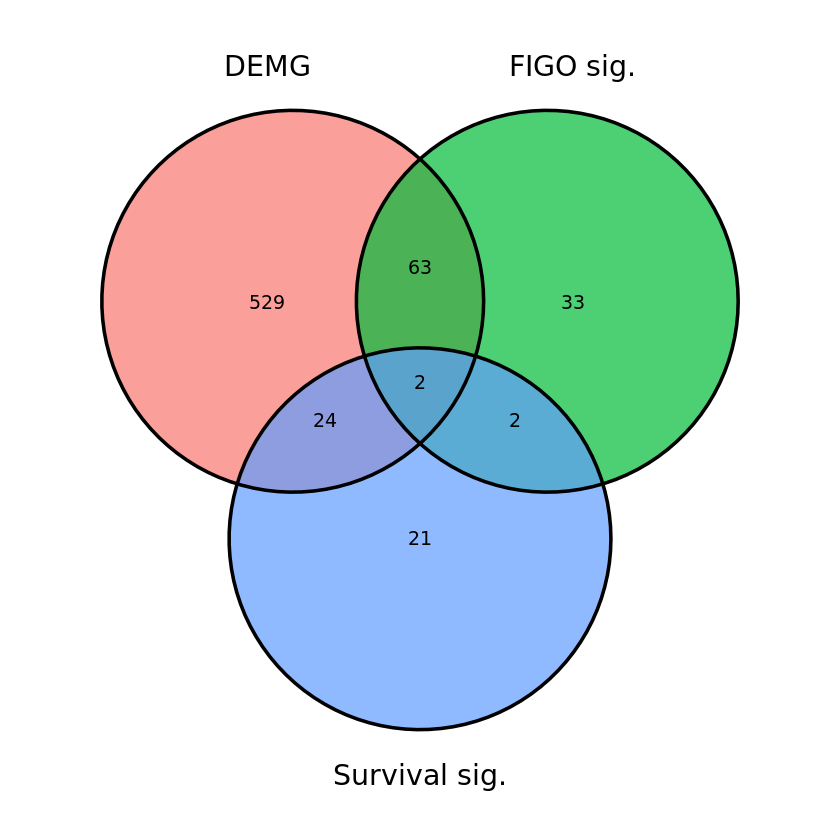

In [9]:
ggplot(data = venn_df) +
    geom_venn(
        aes(A = demg, B = figo, C = survival),
        fill_color = venn_pal,
        fill_alpha = 0.7,
        set_names = c("DEMG", "FIGO sig.", "Survival sig."),
        show_percentage = FALSE
    ) +
    theme_void() +
    theme(
        text = element_text(size = text_size, family = family)
    )
# ggsave(filename = paste0(dirs$figures_dir, "/gene_lists/", unified_dsets[dset_idx], "_intra_overlap_venn.png"), last_plot(), height = vd_ht, width = vd_wd, dpi = dpi)

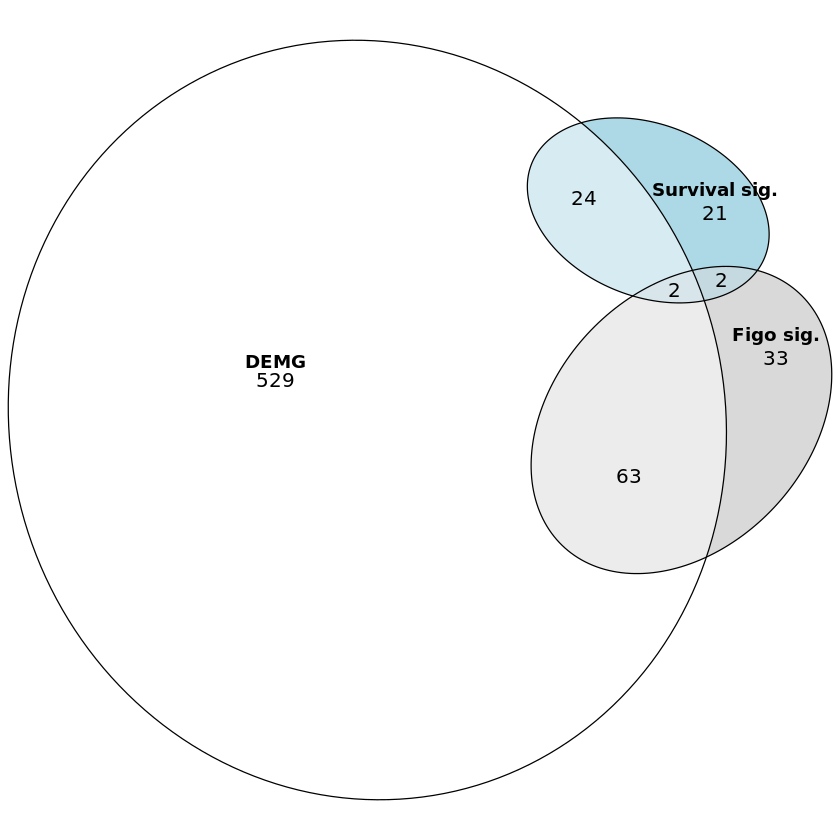

In [10]:
set.seed(123)

euler_df <- venn_df %>%
    column_to_rownames("geneID") %>%
    rename(DEMG = demg, `Figo sig.` = figo, `Survival sig.` = survival)

euler_fit <- euler(euler_df, shape = "ellipse")
eulerr_options(labels = list(fontsize = text_size, fontface = 1))

plot(euler_fit, quantities = TRUE) %>% as.ggplot()

In [11]:
ggsave(filename = paste0(dirs$figures_dir, "/gene_lists/", unified_dsets[dset_idx], "_intra_overlap_euler.png"), last_plot(), height = vd_ht, width = vd_wd, dpi = dpi)